In [ ]:
#Install dependencies
!pip install -U imbalanced-learn
!pip install -U kaleido

In [ ]:
import os
import pandas as pd
import numpy as np
import tarfile
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objs as go
import skimage.io as skio
from imblearn.under_sampling import NearMiss

import keras
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img




import tensorflow as tf
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix



from google.colab import drive

drive.mount('/content/drive')
pio.renderers.default = 'svg'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# reading data
data_raw = pd.read_csv('/content/drive/MyDrive/blinks.csv')
data_raw.head()

,frame_id,left_eye,right_eye,video,blink
0,1,left_000001_rgb.png,right_000001_rgb.png,0,0
1,2,left_000002_rgb.png,right_000002_rgb.png,0,0
2,3,left_000003_rgb.png,right_000003_rgb.png,0,0
3,4,left_000004_rgb.png,right_000004_rgb.png,0,0
4,5,left_000005_rgb.png,right_000005_rgb.png,0,0


In [ ]:
data_raw['blink'].value_counts()

0    116631
1      5216
Name: blink, dtype: int64

In [ ]:
#get all values for Video "00"
df_1 = data_raw[data_raw['video'] == 0]
df_1.shape

(13426, 5)

In [ ]:
no_blink = df_1['blink'].value_counts()[0]
blink = df_1['blink'].value_counts()[1]
print(f'Sin parpadeo : {no_blink} | Parpadeos: {blink}')

Sin parpadeo : 12495 | Parpadeos: 931


In [ ]:
sample = pd.DataFrame([no_blink, blink], index=['Sin parpadeo', 'Parpadeo'])
sample

,0
Sin parpadeo,12495
Parpadeo,931


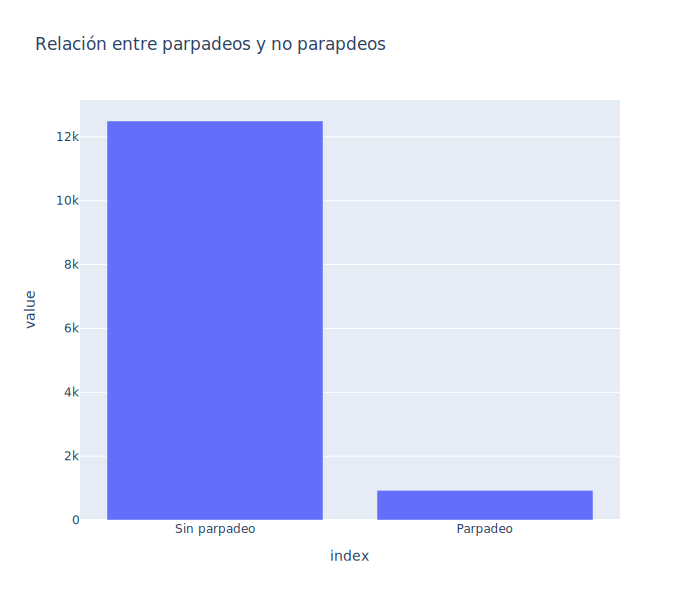

In [ ]:
fig_1 = px.bar(sample, title='Relación entre parpadeos y no parapdeos', width=700, height=600)
fig_1.update_layout(showlegend=False)

In [ ]:
df_1['blink_str'] = np.where(df_1['blink'] == 0, 'No', 'Si')
df_1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,frame_id,left_eye,right_eye,video,blink,blink_str
0,1,left_000001_rgb.png,right_000001_rgb.png,0,0,No
1,2,left_000002_rgb.png,right_000002_rgb.png,0,0,No
2,3,left_000003_rgb.png,right_000003_rgb.png,0,0,No
3,4,left_000004_rgb.png,right_000004_rgb.png,0,0,No
4,5,left_000005_rgb.png,right_000005_rgb.png,0,0,No


In [ ]:
nr = NearMiss() 
x_nr, y_nr = nr.fit_resample(df_1[['frame_id', 'blink']], df_1['blink'])
print('original dataset shape:', df_1['blink'].value_counts()[0])
print('Resample dataset shape', y_nr.value_counts()[0])

original dataset shape: 12495
Resample dataset shape 931


In [ ]:
x_nr.head()

,frame_id,blink
0,2413,0
1,3689,0
2,7793,0
3,12636,0
4,160,0


In [ ]:
df_1[df_1['frame_id'] == 2413]

,frame_id,left_eye,right_eye,video,blink,blink_str
2412,2413,left_002915_rgb.png,right_002915_rgb.png,0,0,No


In [ ]:
df_1 = df_1.loc[df_1['frame_id'].isin(list(x_nr['frame_id']))]
df_1.shape

(1862, 6)

In [ ]:
df_1.head()

,frame_id,left_eye,right_eye,video,blink,blink_str
153,154,left_000154_rgb.png,right_000154_rgb.png,0,0,No
154,155,left_000155_rgb.png,right_000155_rgb.png,0,0,No
155,156,left_000156_rgb.png,right_000156_rgb.png,0,0,No
156,157,left_000157_rgb.png,right_000157_rgb.png,0,0,No
157,158,left_000158_rgb.png,right_000158_rgb.png,0,0,No


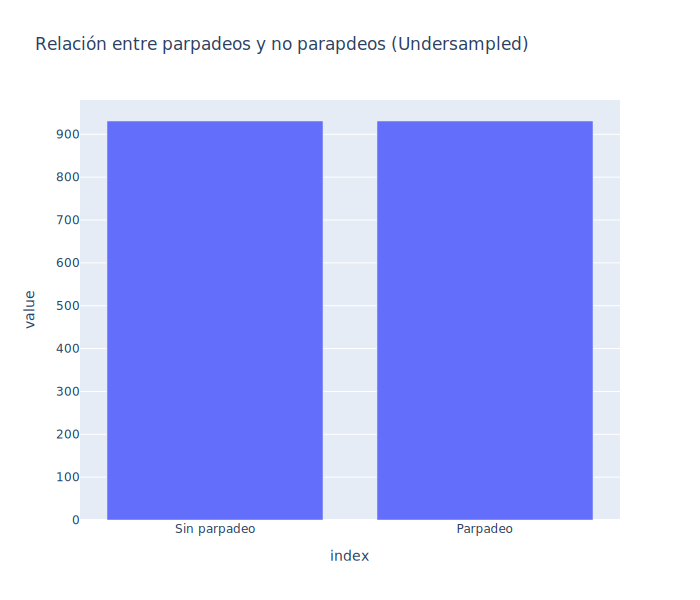

In [ ]:
parpadeos = df_1['blink'].value_counts()[1]
no_parpadeos = df_1['blink'].value_counts()[0]
undersampled = pd.DataFrame([parpadeos, no_parpadeos], index=['Sin parpadeo', 'Parpadeo'])
fig_1 = px.bar(undersampled,title='Relación entre parpadeos y no parapdeos (Undersampled)', 
                     width=700, height=600)
fig_1.update_layout(showlegend=False)

In [ ]:
# Unzip file

file_name = '/content/drive/MyDrive/s000_noglasses_eyes.tar'

with tarfile.open(file_name, 'r') as tar:
  tar.extractall()
  print('Done')

Done


In [ ]:
imgs_right = []
for img in os.listdir('/content/s000_noglasses/natural/right/'):
  imgs_right.append(str('/content/s000_noglasses/natural/right/'+img))

imgs_left = []
for img in os.listdir('/content/s000_noglasses/natural/left/'):
  imgs_left.append(str('/content/s000_noglasses/natural/left/'+img))

def plot_imgs(imgs):
  for i in range(50):
    fig = px.imshow(skio.imread(imgs[i]), width=150, height=100)
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)
    fig.update_layout({
      'plot_bgcolor': 'rgba(0, 0, 0, 0)',
      'paper_bgcolor': 'rgba(0, 0, 0, 0)',
      },
      margin=dict(l=20, r=20, t=5, b=5, pad=1))
    fig.show()

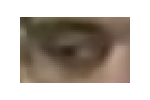

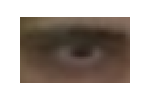

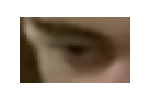

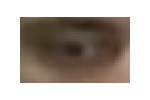

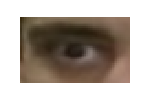

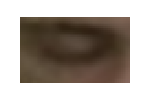

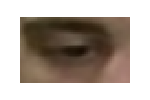

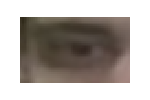

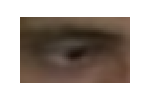

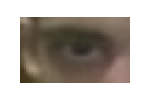

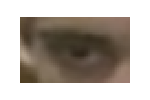

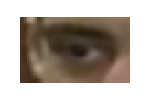

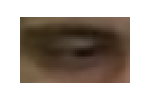

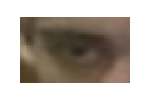

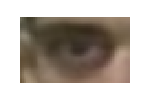

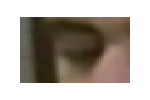

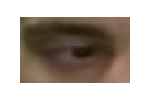

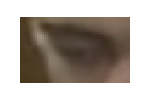

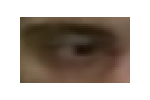

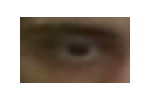

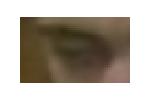

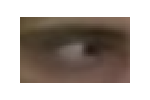

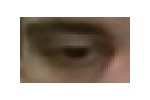

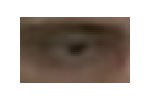

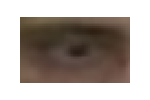

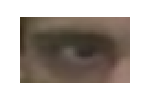

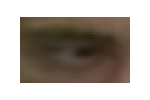

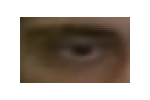

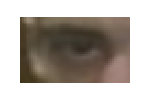

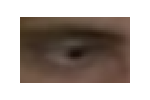

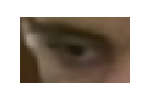

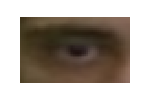

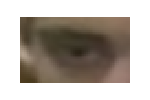

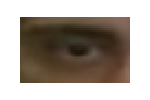

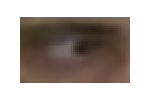

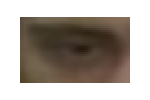

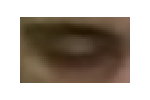

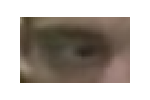

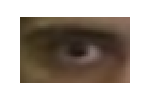

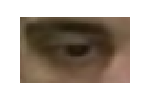

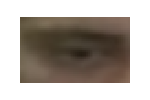

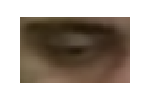

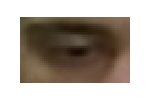

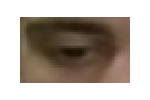

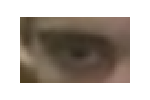

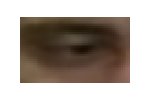

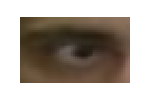

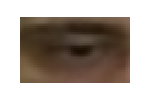

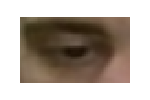

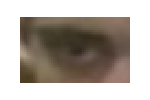

In [ ]:
plot_imgs(imgs_right)

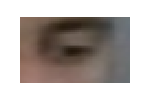

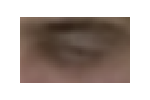

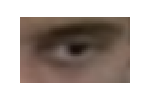

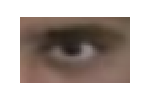

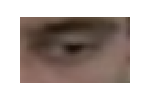

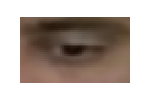

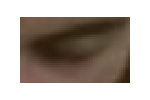

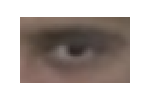

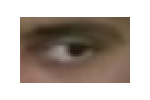

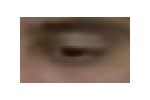

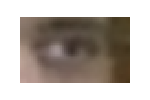

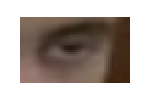

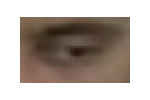

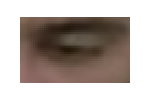

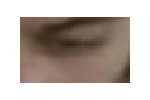

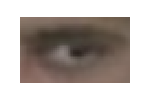

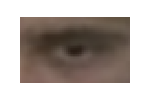

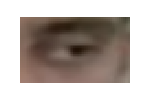

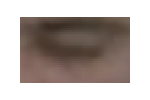

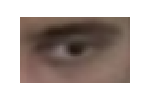

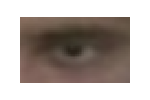

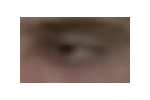

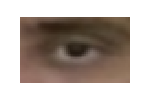

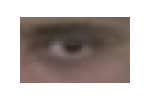

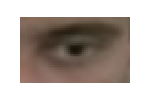

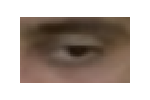

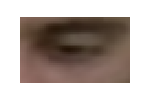

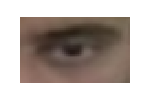

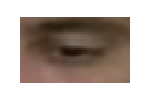

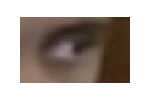

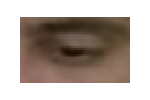

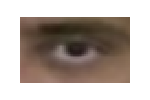

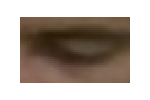

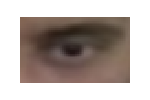

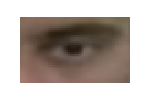

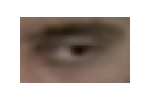

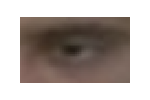

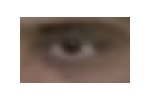

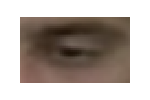

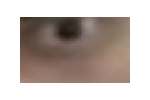

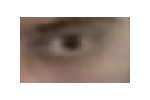

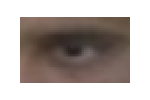

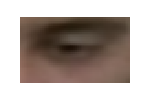

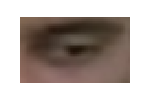

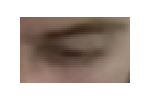

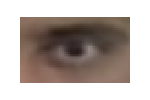

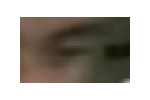

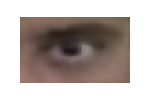

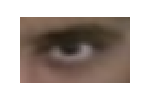

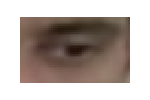

In [ ]:
plot_imgs(imgs_left)

In [ ]:
datagen = ImageDataGenerator()
left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink_str'
batch_size = 500
img_width = 60
img_height = 36
imgs_path_right = '/content/s000_noglasses/natural/right/'
imgs_path_left = '/content/s000_noglasses/natural/left/'
def generator(dataframe):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                  directory = imgs_path_left,
                                                  target_size =(img_width, img_height),
                                                  x_col=left_eye_col,
                                                  y_col=y_col,
                                                  class_mode="binary",
                                                  batch_size=batch_size)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                    directory = imgs_path_right,
                                                    target_size =(img_width, img_height),
                                                    x_col=right_eye_col,
                                                    y_col=y_col,
                                                    class_mode="binary",
                                                    batch_size=batch_size)
  
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    # yield [left_eye_image, right_eye_image], label
    return [left_eye_image, right_eye_image], label
    


In [ ]:
total = generator(df_1)

Found 1862 validated image filenames belonging to 2 classes.
Found 1862 validated image filenames belonging to 2 classes.


In [ ]:
right = total[0][1]
left = total[0][0]
label = total[1]

In [ ]:
x_train_comp = np.stack((right, left), axis=4)

In [ ]:
#split train and validation
X_train, X_test, y_train, y_test = train_test_split(x_train_comp, label, test_size=0.20)

In [ ]:
X_train_left = X_train[:,:,:,:,0]
X_train_right = X_train[:,:,:,:,1]

X_test_left = X_test[:,:,:,:,0]
X_test_right = X_test[:,:,:,:,1]

In [ ]:
input_shape = (240, 144, 3)

In [ ]:
def create_convolution_layers(input_img):
  model = Conv2D(64, (1, 1), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(1, 1),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(32, (1, 1), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(3, (1, 1), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)
  return model

In [ ]:
# red neuronal

input_left = Input(shape=input_shape)
input_right = Input(shape=input_shape)

right_model = create_convolution_layers(input_right)
left_model = create_convolution_layers(input_left)

combined = concatenate([left_model, right_model])
combined = Flatten()(combined)
dense = Dense(240)(combined)
leaky = LeakyReLU(alpha=0.1)(dense)
drop = Dropout(0.5)(leaky)

output = Dense(1, activation='sigmoid')(drop)

model = Model(inputs = [left_model, right_model], outputs = [output])
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 60, 36, 6)    0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 12960)        0           ['concatenate[1][0]']        

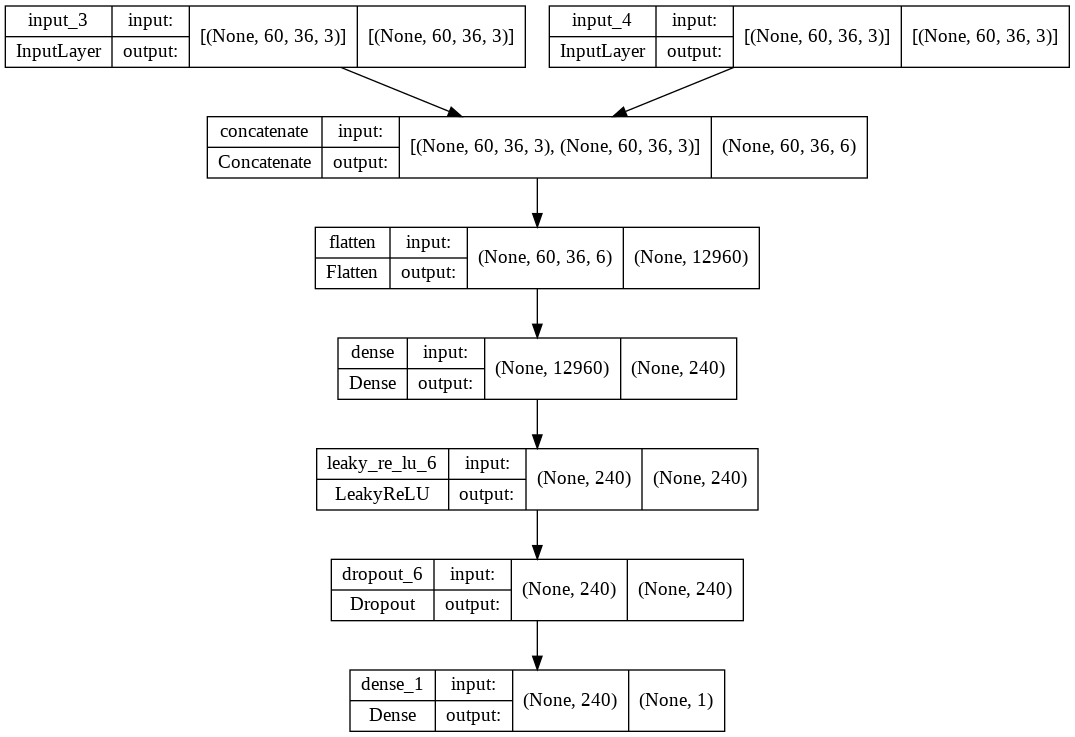

In [ ]:
plot_model(model, 'Modelo_Propio.png', show_shapes=True)

In [ ]:
history = model.fit([X_train_left, X_train_right], y_train, 
                    epochs = 500 , 
                    validation_data = 
                    ([X_test_left, X_test_right], 
                     y_test), 
                    verbose = 1)

Epoch 1/500
13/13 [==============================] - 2s 61ms/step - loss: 138.8985 - accuracy: 0.5150 - val_loss: 53.3249 - val_accuracy: 0.5200
Epoch 2/500
13/13 [==============================] - 0s 36ms/step - loss: 49.0411 - accuracy: 0.5475 - val_loss: 35.6541 - val_accuracy: 0.4800
Epoch 3/500
13/13 [==============================] - 0s 35ms/step - loss: 34.3802 - accuracy: 0.5225 - val_loss: 15.0080 - val_accuracy: 0.4800
Epoch 4/500
13/13 [==============================] - 0s 34ms/step - loss: 21.5599 - accuracy: 0.5525 - val_loss: 6.6296 - val_accuracy: 0.6000
Epoch 5/500
13/13 [==============================] - 1s 43ms/step - loss: 15.8183 - accuracy: 0.6050 - val_loss: 3.8258 - val_accuracy: 0.7100
Epoch 6/500
13/13 [==============================] - 0s 31ms/step - loss: 15.0108 - accuracy: 0.5675 - val_loss: 7.7593 - val_accuracy: 0.6000
Epoch 7/500
13/13 [==============================] - 0s 33ms/step - loss: 12.1633 - accuracy: 0.6350 - val_loss: 15.9793 - val_accuracy: 0

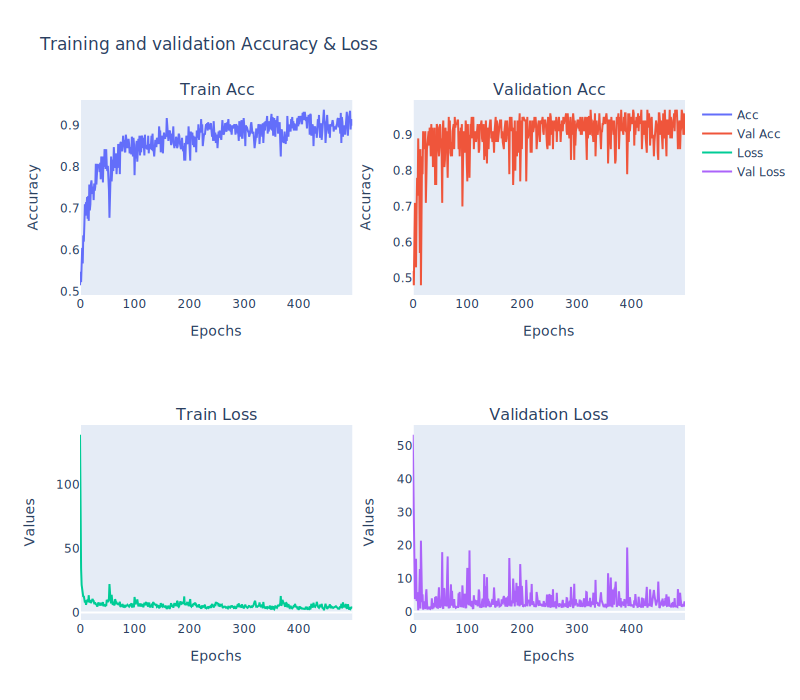

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(500)

fig = make_subplots(rows=2, cols=2, subplot_titles=("Train Acc", "Validation Acc", "Train Loss", "Validation Loss"))
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = acc, mode = 'lines', name ='Acc'), row=1, col = 1)
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = val_acc, mode = 'lines',name ='Val Acc'), row=1, col = 2)
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = loss, mode = 'lines', name ='Loss'), row=2, col = 1)
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = val_loss, mode = 'lines', name='Val Loss'), row=2, col = 2)

# Update xaxis properties
fig.update_xaxes(title_text="Epochs", showgrid=False, row=1, col=1)
fig.update_xaxes(title_text="Epochs", showgrid=False, row=1, col=2)
fig.update_xaxes(title_text="Epochs", showgrid=False, row=2, col=1)
fig.update_xaxes(title_text="Epochs", showgrid=False, row=2, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", showgrid=False, row=1, col=1)
fig.update_yaxes(title_text="Accuracy", showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="Values", showgrid=False, row=2, col=1)
fig.update_yaxes(title_text="Values", showgrid=False, row=2, col=2)
fig.update_layout(height=700, width=800, title_text="Training and validation Accuracy & Loss")
fig.show()


In [ ]:
final_loss, final_acc = model.evaluate([X_test_left, X_test_right], y_test, verbose = 1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

4/4 [==============================] - 0s 7ms/step - loss: 2.1978 - accuracy: 0.9300
Final loss: 2.197752, final accuracy: 0.930000


In [ ]:
y_predict = model.predict([X_test_left, X_test_right])

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict([X_test_left, X_test_right], verbose=0)
yhat_classes = y_predict.astype('int32')

In [ ]:
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.945312
Accuracy: 0.940000
Precision: 0.910714
Recall: 0.980769
F1 score: 0.944444
[[43  5]
 [ 1 51]]


In [ ]:
# pre-trained model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
resent_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(64, 36, 3))
for layer in resent_model.layers:
    layer.trainable = False
resent_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 36, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 42, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 18, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 20, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [ ]:
right_preTrained_model = Conv2D(64, (1, 1), padding='same')(resent_model.output)
right_preTrained_model = MaxPooling2D(pool_size=(2, 2))(right_preTrained_model)
right_preTrained_model = Dense(36,activation='relu')(right_preTrained_model)
right_preTrained_model = Dense(3,activation='softmax')(right_preTrained_model)


left_preTrained_model = Conv2D(64, (1, 1), padding='same')(resent_model.output)
left_preTrained_model = MaxPooling2D(pool_size=(2, 2))(left_preTrained_model)
left_preTrained_model = Dense(36,activation='relu')(left_preTrained_model)
left_preTrained_model = Dense(3,activation='softmax')(left_preTrained_model)

preTrained_combined = concatenate([left_preTrained_model, right_preTrained_model])

In [ ]:
flatten = Flatten()(preTrained_combined)
drop = Dropout(0.5)(flatten)
output = Dense(1, activation='sigmoid')(drop)


preTrained_model = Model(inputs = [left_preTrained_model, right_preTrained_model], outputs = output)

opt = Adam(learning_rate=0.0001)
preTrained_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
preTrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1, 1, 3)]    0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1, 1, 3)]    0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 6)      0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 6)            0           ['concatenate_1[1][0]']    

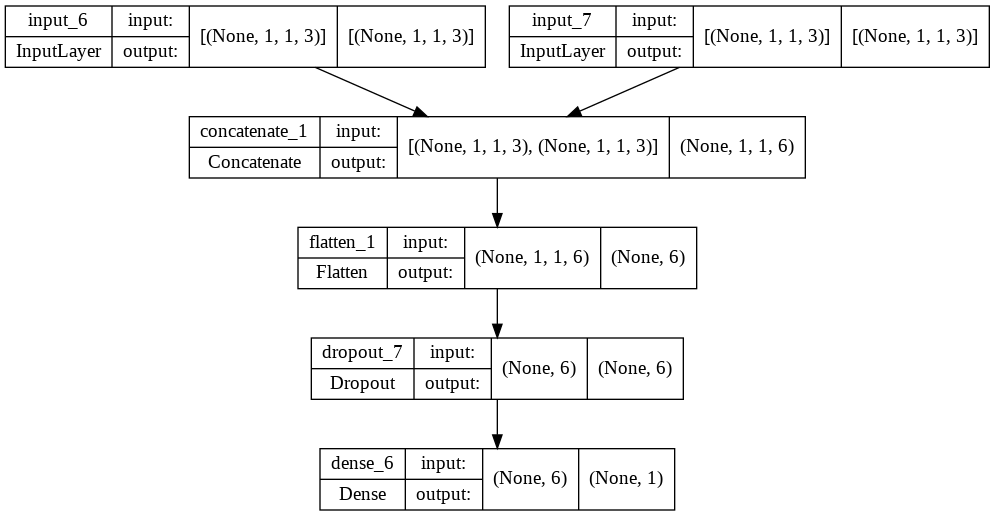

In [ ]:
plot_model(preTrained_model, "CNN_PreEntrenada.png", show_shapes=True)

In [ ]:
datagen = ImageDataGenerator()
left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink_str'
batch_size = 500
img_width = 1
img_height = 1
imgs_path_right = '/content/s000_noglasses/natural/right/'
imgs_path_left = '/content/s000_noglasses/natural/left/'

In [ ]:
preTrained_data = generator(df_1)

Found 1862 validated image filenames belonging to 2 classes.
Found 1862 validated image filenames belonging to 2 classes.


In [ ]:
right = preTrained_data[0][1]
left = preTrained_data[0][0]
label = preTrained_data[1]

x_train_comp = np.stack((right, left), axis=4)
X_train, X_test, y_train, y_test = train_test_split(x_train_comp, label, test_size=0.20)

X_train_left = X_train[:,:,:,:,0]
X_train_right = X_train[:,:,:,:,1]

X_test_left = X_test[:,:,:,:,0]
X_test_right = X_test[:,:,:,:,1]

In [ ]:
hist = preTrained_model.fit([X_train_left, X_train_right], y_train, 
                    epochs = 500 , 
                    validation_data = 
                    ([X_test_left, X_test_right], 
                     y_test), 
                    verbose = 1)

Epoch 1/500
13/13 [==============================] - 1s 14ms/step - loss: 41.1779 - accuracy: 0.4350 - val_loss: 20.2610 - val_accuracy: 0.4900
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: 37.7852 - accuracy: 0.4750 - val_loss: 20.1642 - val_accuracy: 0.4900
Epoch 3/500
13/13 [==============================] - 0s 5ms/step - loss: 34.0938 - accuracy: 0.5075 - val_loss: 20.0736 - val_accuracy: 0.4900
Epoch 4/500
13/13 [==============================] - 0s 4ms/step - loss: 38.4745 - accuracy: 0.5175 - val_loss: 19.9720 - val_accuracy: 0.4900
Epoch 5/500
13/13 [==============================] - 0s 5ms/step - loss: 45.4275 - accuracy: 0.4225 - val_loss: 19.8812 - val_accuracy: 0.4900
Epoch 6/500
13/13 [==============================] - 0s 5ms/step - loss: 41.9782 - accuracy: 0.4375 - val_loss: 19.8155 - val_accuracy: 0.4900
Epoch 7/500
13/13 [==============================] - 0s 4ms/step - loss: 38.9870 - accuracy: 0.4450 - val_loss: 19.7263 - val_accuracy: 0.490

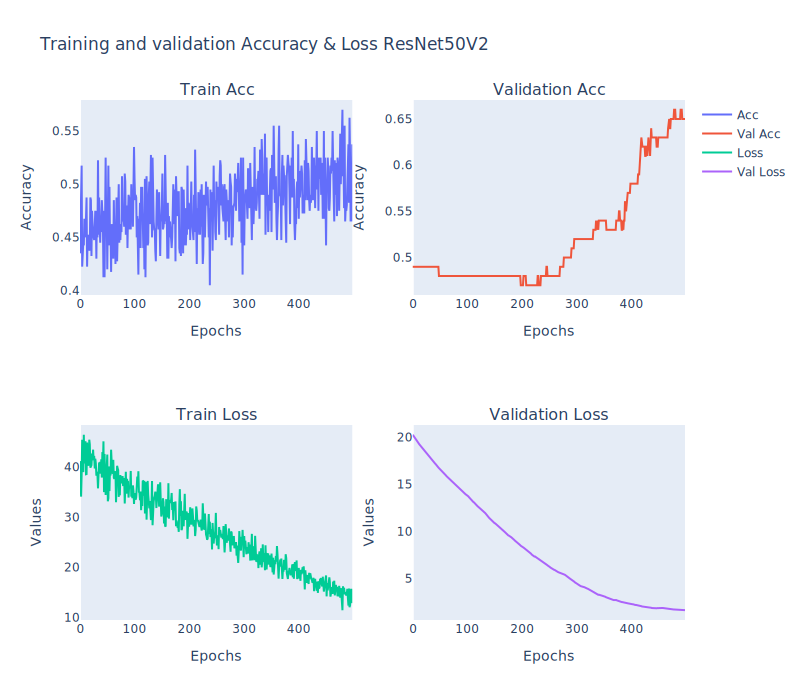

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(500)

fig = make_subplots(rows=2, cols=2, subplot_titles=("Train Acc", "Validation Acc", "Train Loss", "Validation Loss"))
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = acc, mode = 'lines', name ='Acc'), row=1, col = 1)
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = val_acc, mode = 'lines',name ='Val Acc'), row=1, col = 2)
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = loss, mode = 'lines', name ='Loss'), row=2, col = 1)
fig.add_trace(go.Scatter(x = np.array(epochs_range), y = val_loss, mode = 'lines', name='Val Loss'), row=2, col = 2)

# Update xaxis properties
fig.update_xaxes(title_text="Epochs", showgrid=False, row=1, col=1)
fig.update_xaxes(title_text="Epochs", showgrid=False, row=1, col=2)
fig.update_xaxes(title_text="Epochs", showgrid=False, row=2, col=1)
fig.update_xaxes(title_text="Epochs", showgrid=False, row=2, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", showgrid=False, row=1, col=1)
fig.update_yaxes(title_text="Accuracy", showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="Values", showgrid=False, row=2, col=1)
fig.update_yaxes(title_text="Values", showgrid=False, row=2, col=2)
fig.update_layout(height=700, width=800, title_text="Training and validation Accuracy & Loss ResNet50V2")
fig.show()

In [ ]:
final_loss, final_acc = preTrained_model.evaluate([X_test_left, X_test_right], y_test, verbose = 1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

4/4 [==============================] - 0s 3ms/step - loss: 1.6494 - accuracy: 0.6500
Final loss: 1.649413, final accuracy: 0.650000


In [ ]:
y_predict = preTrained_model.predict([X_test_left, X_test_right])
yhat_probs = preTrained_model.predict([X_test_left, X_test_right], verbose=0)
yhat_classes = y_predict.round().astype('int32')

In [ ]:
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

matrix = confusion_matrix(y_test, yhat_classes)
print('')
print(f'CONFUSION MATRIX')
print('-----------------')
print(matrix)

ROC AUC: 0.669868
Accuracy: 0.650000
Precision: 0.600000
Recall: 0.857143
F1 score: 0.705882

CONFUSION MATRIX
-----------------
[[23 28]
 [ 7 42]]


In [ ]:
model.save("/content/drive/MyDrive/modelo_propuesto.hdf5")
preTrained_model.save("/content/drive/MyDrive/modelo_prentrenado.hdf5")

In [ ]:
%%shell
jupyter nbconvert --to html /content/Blink_Prediction.ipynb

[NbConvertApp] Converting notebook /content/Blink_Prediction.ipynb to html
[NbConvertApp] Writing 1793549 bytes to /content/Blink_Prediction.html
